##### Copyright 2020 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.


## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.


In [ ]:
# # Step 1: Install TensorFlow and Datasets
# %pip install -U -q tensorflow tensorflow_datasets

# # Step 2: Install Wrapt
# %pip install wrapt==1.14.1

# # Step 3: Install Visualization Libraries
# %pip install matplotlib seaborn

# # Step 4: Install PySoundFile
# %pip install pysoundfile

# # Step 5: Reinstall TensorFlow I/O
# # !pip uninstall -y tensorflow-io 
# %pip install tensorflow-io
# # %pip install --upgrade tensorflow

# %pip install nbformat

# # Step 6: Install IPykernel
# %pip install ipykernel

# %pip install ipynb

# %pip install pickleshare

# %pip install librosa

# %pip install AudioSegment



     ---------------------------------------- 66.2/66.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp311-cp311-win_amd64.whl size=18860 sha256=c0d75407280d30964a0cef920f29aad7a24d5c6ad700ac6c1056edbd0bc48f86
  Stored in directory: c:\users\prett\appdata\local\pip\cache\wheels\53\6a\ba\6b7046376cfe344494d109cfb907ecd1ad906017bfaa8d1acb
Successfully built webrtcvad
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:

import pathlib
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
# import tensorflow_io as tfio
from IPython import get_ipython
import matplotlib.pyplot as plt
from collections import Counter

import seaborn as sns
from sklearn.metrics import confusion_matrix

DATA_DIR = pathlib.Path('data')

SECONDS = 10
BATCH_SIZE = 64


# # small Dataset
# TRAIN_DIR = pathlib.Path('data/small_train_ds')
# TEST_DIR = pathlib.Path('data/small_test_ds')
# VAL_DIR = pathlib.Path('data/small_val_ds')

# # medium Dataset
# TRAIN_DIR = pathlib.Path('data/medium_train_ds')
# VAL_DIR = pathlib.Path('data/medium_val_ds')
# TEST_DIR = pathlib.Path('data/medium_test_ds')


# large Dataset
TRAIN_DIR = pathlib.Path('data/large_train_ds')
VAL_DIR = pathlib.Path('data/large_val_ds')
TEST_DIR = pathlib.Path('data/medium_test_ds')


import ipynb.fs.defs.audio_extraction as audio_extraction
import ipynb.fs.defs.build_database as build_database
import ipynb.fs.defs.build_spectogram_ds as wave_to_spec
import ipynb.fs.defs.build_train_model as build_train_model
import ipynb.fs.defs.handle_ai_model as handle_ai_model


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Gefundene GPUs: {gpus}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("Keine GPUs gefunden, TensorFlow wird auf der CPU ausgefuehrt.")

2.18.0
Keine GPUs gefunden, TensorFlow wird auf der CPU ausgefuehrt.


# Extract

In [4]:
def notebook_extract():
    audio_extraction.extract_zip(TRAIN_DIR, DATA_DIR)
    print('-' * 50)  
    audio_extraction.extract_zip(TEST_DIR, DATA_DIR)
    print('-' * 50)  
    audio_extraction.extract_zip(VAL_DIR, DATA_DIR)
    print('-' * 50)
    print('-' * 50)  
    audio_extraction.rename_audio_files(DATA_DIR)
    print('-' * 50)
    print('-' * 50)  
    # audio_extraction.process_directory(TRAIN_DIR) 
    # audio_extraction.process_directory(VAL_DIR)
    # audio_extraction.process_directory(TEST_DIR)  

notebook_extract()

Das Verzeichnis data\large_train_ds existiert bereits. Ãœberspringe das Extrahieren.
--------------------------------------------------
Das Verzeichnis data\medium_test_ds existiert bereits. Ãœberspringe das Extrahieren.
--------------------------------------------------
Das Verzeichnis data\large_val_ds existiert bereits. Ãœberspringe das Extrahieren.
--------------------------------------------------
--------------------------------------------------
renaming of data/data complete
renaming of data/large_train_ds complete
renaming of data/orig-16-44-mono complete
renaming of data/upscale-from-mp3-128 complete
renaming of data/large_val_ds complete
renaming of data/orig-16-44-mono complete
renaming of data/upscale-from-mp3-128 complete
renaming of data/medium_test_ds complete
renaming of data/orig-16-44-mono complete
renaming of data/upscale-from-mp3-128 complete
renaming of data/medium_train_ds complete
renaming of data/orig-16-44-mono complete
renaming of data/upscale-from-mp3-128 co

# Database

In [5]:
train_ds, val_ds, test_ds, label_names = build_database.run(TRAIN_DIR, TEST_DIR, DATA_DIR, VAL_DIR, SECONDS, BATCH_SIZE)

Split Tracks in 10 seconds
Anzahl samples fuer data\large_train_ds: 5192
Batch Size: 64
Manuell gesetzte label names fuer data\large_train_ds:  ['orig-16-44-mono' 'upscale-from-mp3-128']
Split Tracks in 10 seconds
Anzahl samples fuer data\large_val_ds: 1134
Batch Size: 64
Manuell gesetzte label names fuer data\large_val_ds:  ['orig-16-44-mono' 'upscale-from-mp3-128']
Split Tracks in 10 seconds
Anzahl samples fuer data\medium_test_ds: 22
Batch Size: 22
Manuell gesetzte label names fuer data\medium_test_ds:  ['orig-16-44-mono' 'upscale-from-mp3-128']


# Convert waveforms to spectrograms

Loaded label_names (before play): ['orig-16-44-mono' 'upscale-from-mp3-128']
Label: upscale-from-mp3-128
Waveform shape: (441000,)
Spectrogram shape: (3444, 129, 1)
Audio playback


Label: upscale-from-mp3-128
Waveform shape: (441000,)
Spectrogram shape: (3444, 129, 1)
Audio playback


Label: upscale-from-mp3-128
Waveform shape: (441000,)
Spectrogram shape: (3444, 129, 1)
Audio playback


i:\Uni-Git\Master\Tutorial\build_spectogram_ds.ipynb:107: RuntimeWarning: invalid value encountered in log
  "    print('Label:', label)\n",


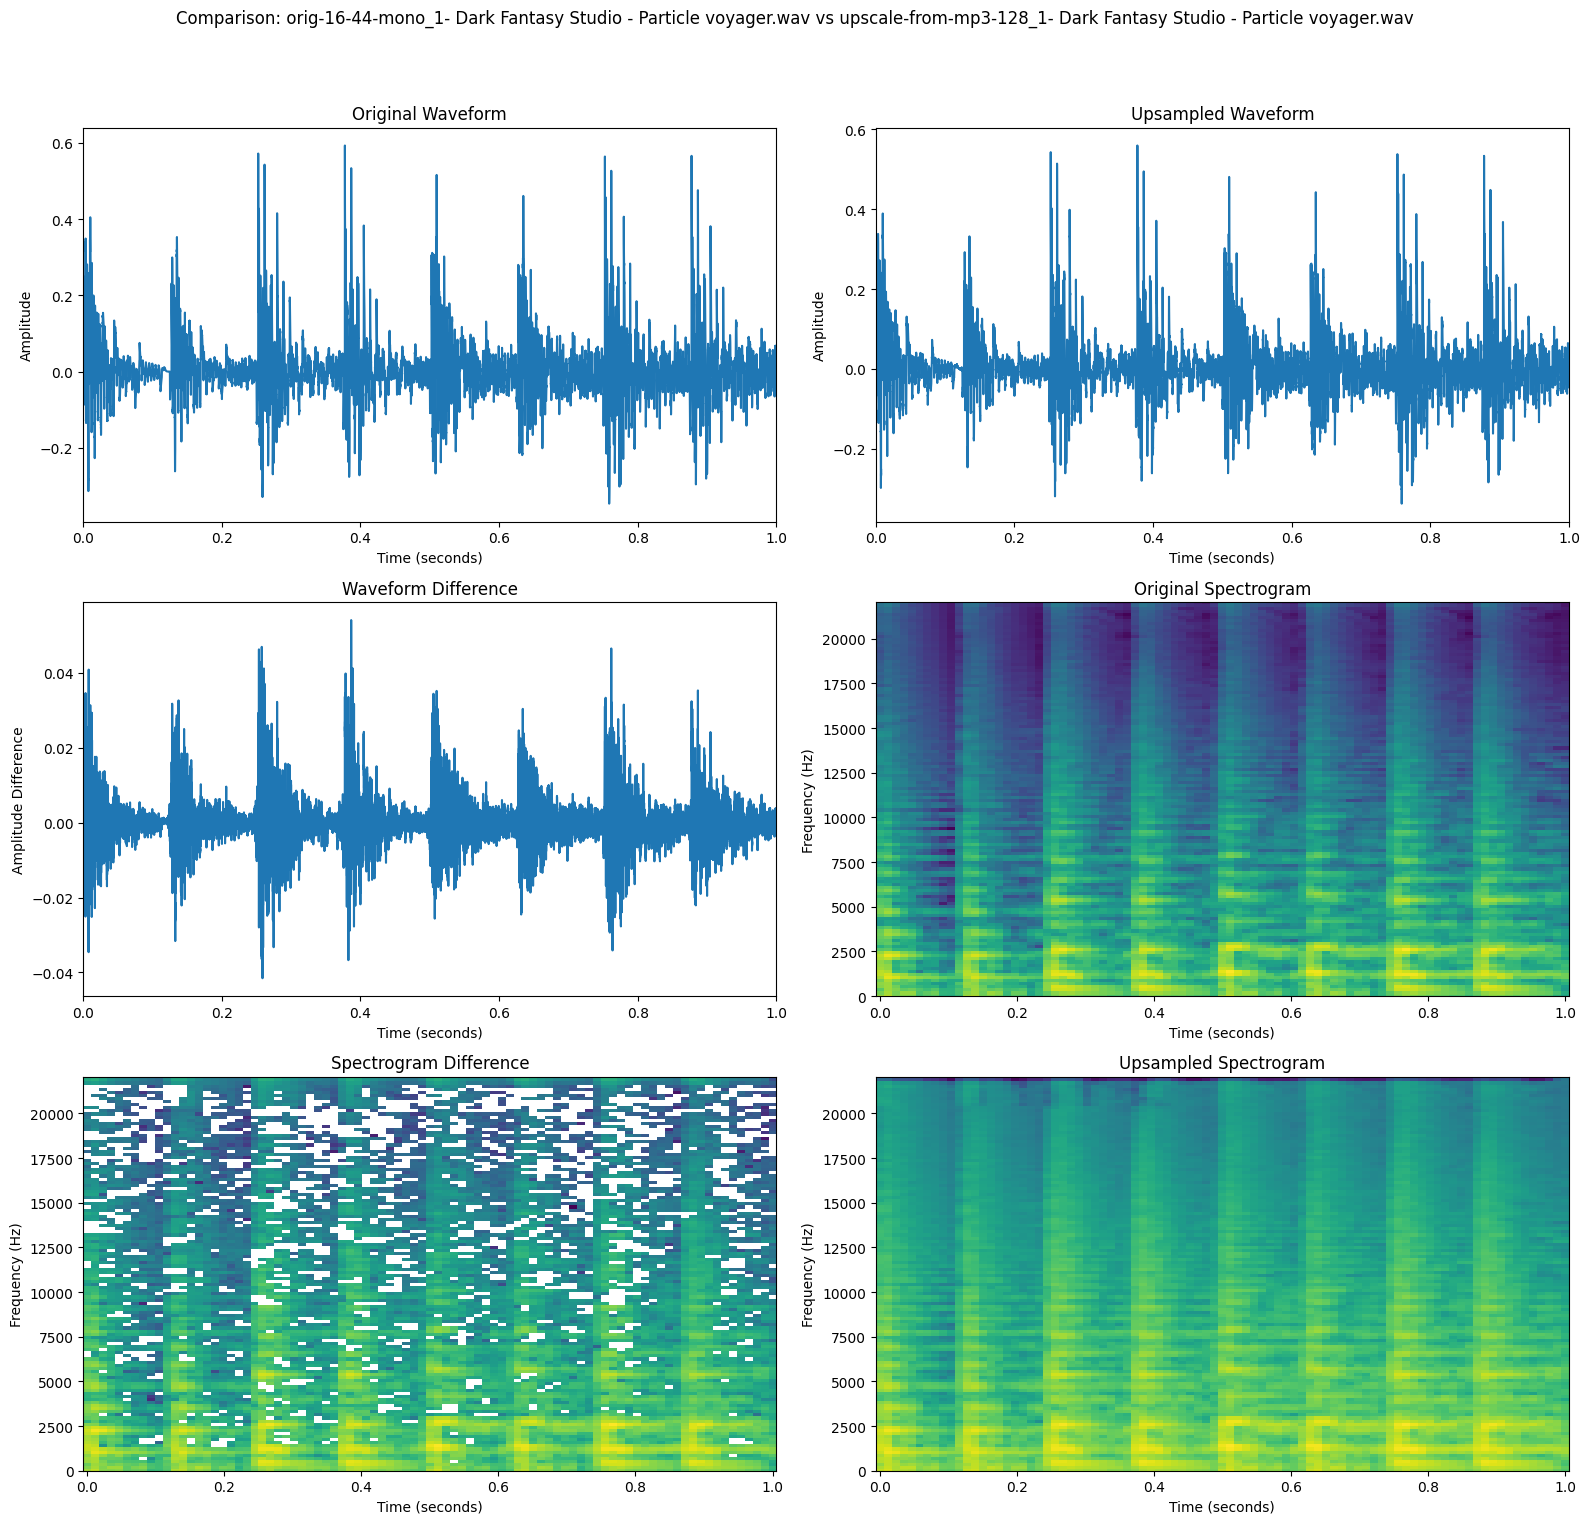

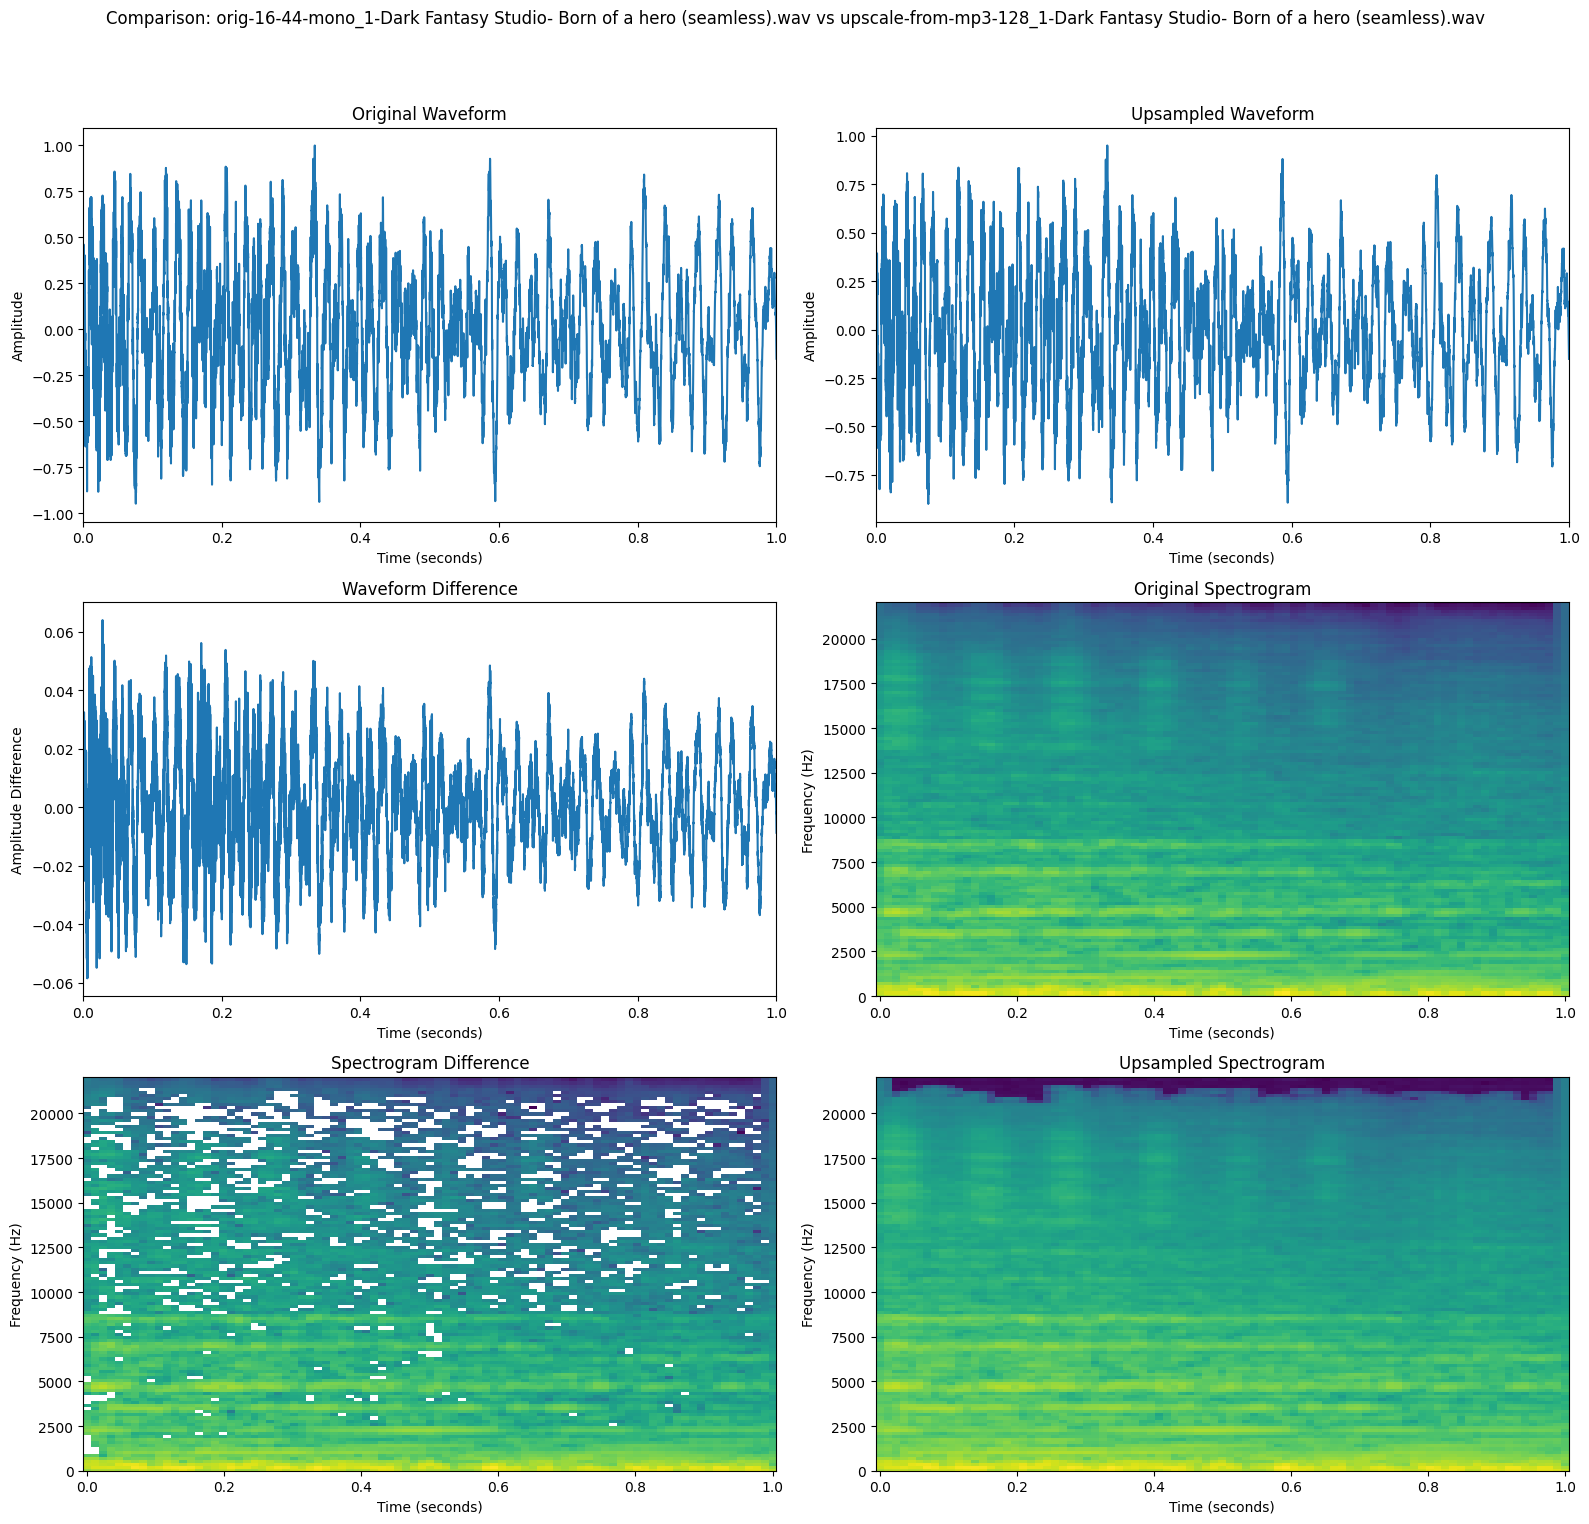

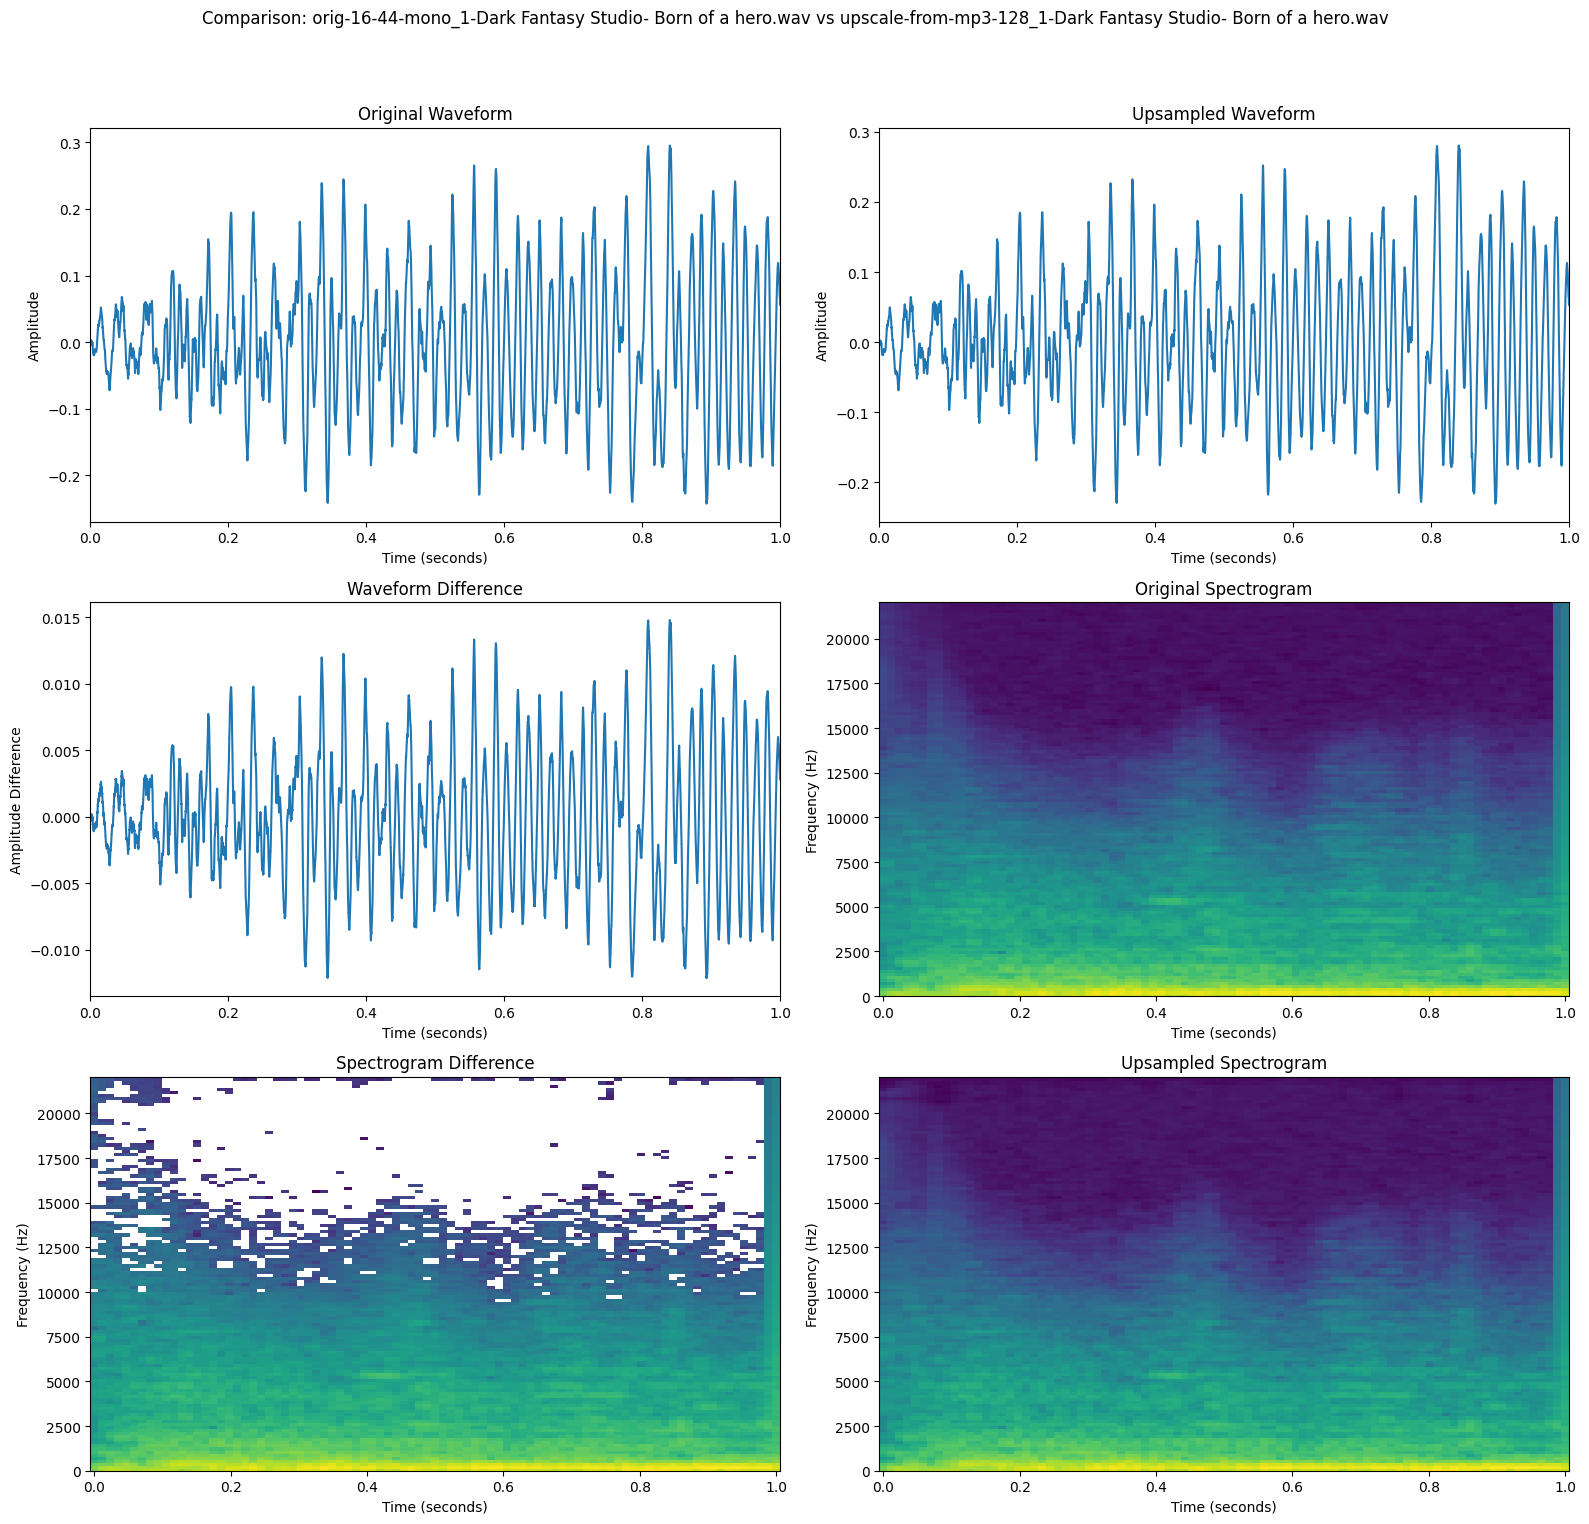

Loaded label_names (after play): ['orig-16-44-mono' 'upscale-from-mp3-128']


In [6]:
train_spectrogram_ds, val_spectrogram_ds, test_spectrogram_ds = wave_to_spec.run(label_names, train_ds, val_ds, test_ds)

## Build and train the model


In [7]:
train_spectrogram_ds, val_spectrogram_ds, test_spectrogram_ds, model, history = build_train_model.run(train_spectrogram_ds, val_spectrogram_ds, test_spectrogram_ds, label_names)

Input shape: (3444, 129, 1)
num_labels: 2


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,204,901 (4.60 MB)

 Trainable params: 1,204,658 (4.60 MB)

 Non-trainable params: 243 (976.00 B)

Number of training files: 5192
Number of validation files: 1134
Start of run 1/2
Epoch 1/2000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4974 - loss: 1.4967
Epoch 1/2000 - Estimated time until finished: 6 hours, 4 minutes, 17 seconds
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.4974 - loss: 1.4941 - val_accuracy: 0.5000 - val_loss: 1.0383
Epoch 2/2000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5405 - loss: 1.0238
Epoch 2/2000 - Estimated time until finished: 3 hours, 32 minutes, 46 seconds
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5405 - loss: 1.0237 - val_accuracy: 0.5000 - val_loss: 1.1214
Epoch 3/2000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5848 - loss: 0.9778
Epoch 3/2000 - Estimated time until finished: 2 hours, 42 minutes, 11 seconds
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5849 - loss: 0.9778 - val_accuracy: 0.5000 - val_loss: 1.3011
Epoch 4/2000
80/82 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6206 - lo

## Handle AI Model


{'accuracy': [0.5042372941970825, 0.5452619194984436, 0.5891756415367126, 0.6253852248191833, 0.651001513004303, 0.6685284972190857, 0.6904853582382202, 0.6993451714515686, 0.7207241654396057, 0.7293913960456848, 0.7446070909500122, 0.7463405132293701, 0.7700307965278625, 0.777157187461853, 0.7848613262176514, 0.785439133644104, 0.8102850317955017, 0.8251155614852905, 0.8445685505867004, 0.8597843050956726, 0.866525411605835, 0.8959938287734985, 0.8751925826072693, 0.9218027591705322, 0.912365198135376, 0.8828967809677124, 0.9356702566146851, 0.9472265243530273, 0.9555084705352783, 0.9530045986175537, 0.9634052515029907, 0.954352855682373, 0.9614791870117188, 0.9672573208808899, 0.965523898601532, 0.9666795134544373, 0.9682203531265259, 0.965523898601532, 0.9714946150779724, 0.9595531821250916, 0.928158700466156, 0.9518489837646484, 0.9684129357337952, 0.972072422504425, 0.9711093902587891, 0.9661017060279846, 0.9705315828323364, 0.9741910696029663, 0.9788135886192322, 0.97881358861923

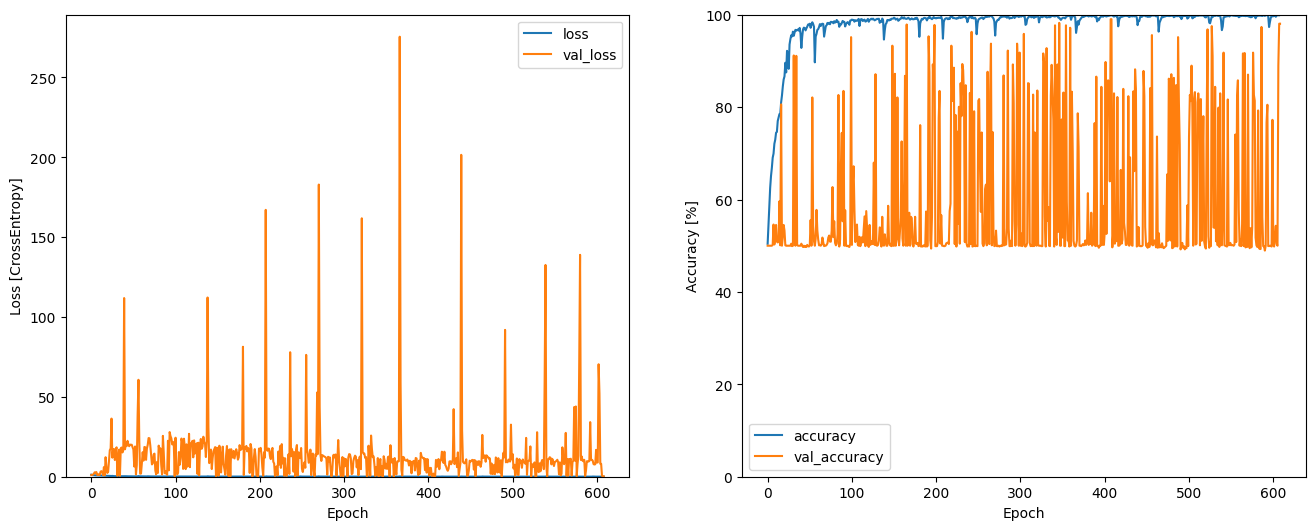

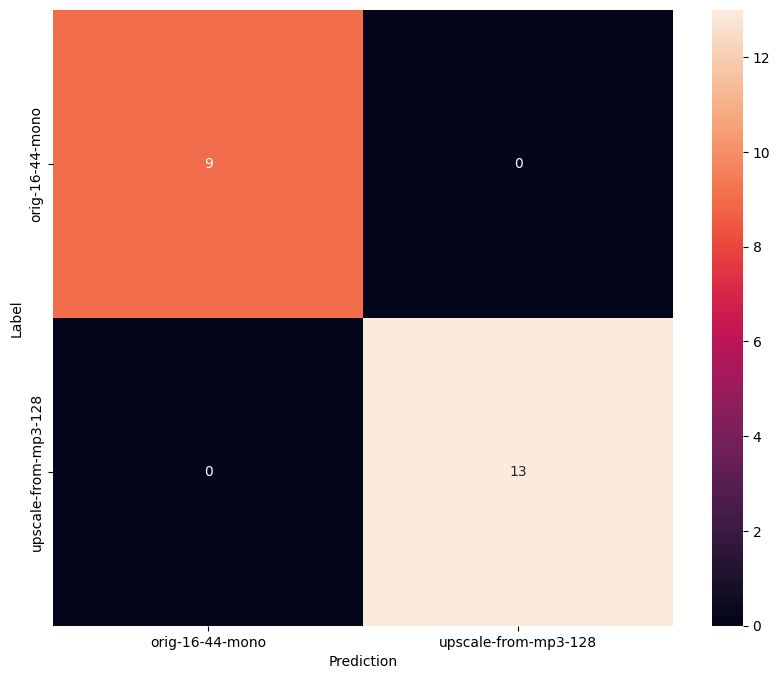

Verarbeite Datei: data\medium_test_ds\orig-16-44-mono\orig-16-44-mono_14-Dark Fantasy Studio- Medieval fiesta.wav
Form des Audiosignals: (44100,)
Sample Rate: 44100


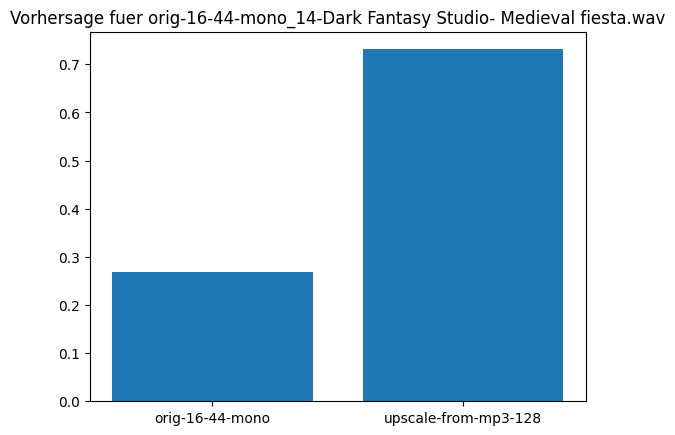

Verarbeite Datei: data\medium_test_ds\orig-16-44-mono\orig-16-44-mono_4-Dark Fantasy Studio- Hide and seek.wav
Form des Audiosignals: (44100,)
Sample Rate: 44100


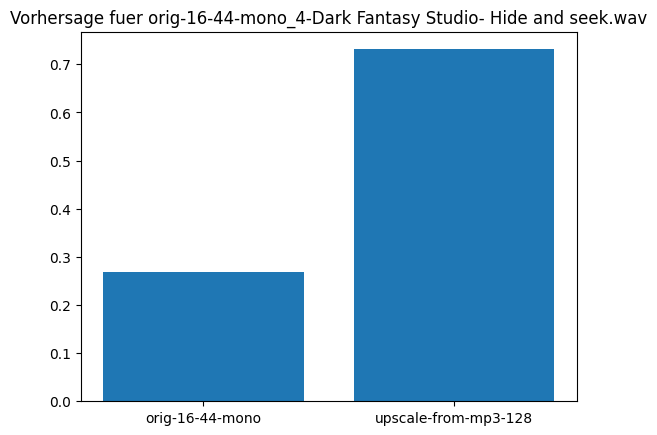

Verarbeite Datei: data\medium_test_ds\orig-16-44-mono\orig-16-44-mono_Fatality Racer.wav
Form des Audiosignals: (44100,)
Sample Rate: 44100


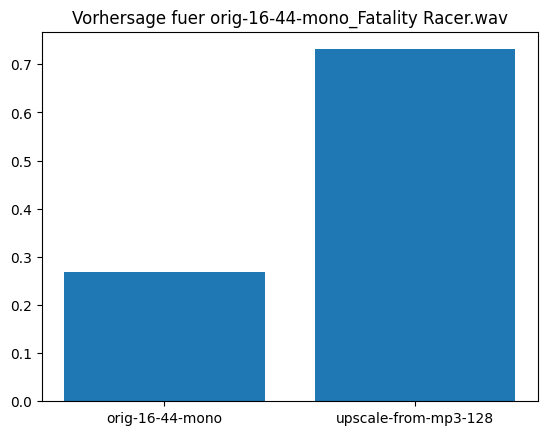

Verarbeite Datei: data\medium_test_ds\upscale-from-mp3-128\upscale-from-mp3-128_14-Dark Fantasy Studio- Medieval fiesta.wav
Form des Audiosignals: (44100,)
Sample Rate: 44100


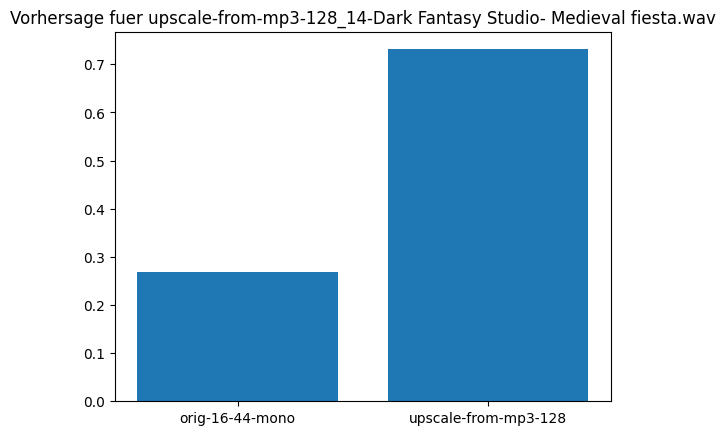

Verarbeite Datei: data\medium_test_ds\upscale-from-mp3-128\upscale-from-mp3-128_4-Dark Fantasy Studio- Hide and seek.wav
Form des Audiosignals: (44100,)
Sample Rate: 44100


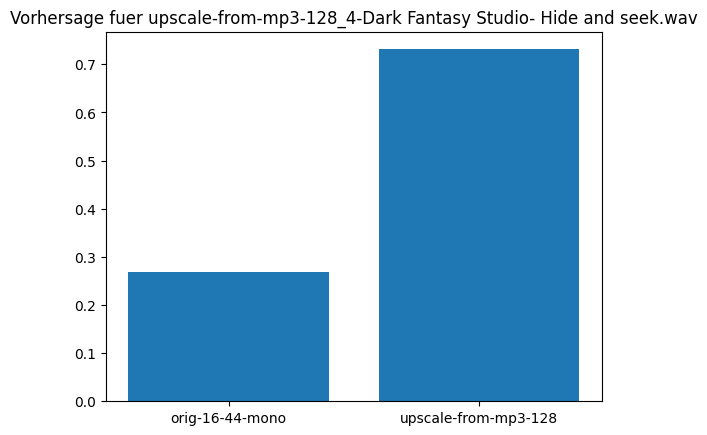

Verarbeite Datei: data\medium_test_ds\upscale-from-mp3-128\upscale-from-mp3-128_Casual Theme Loop.wav
Form des Audiosignals: (44100,)
Sample Rate: 44100


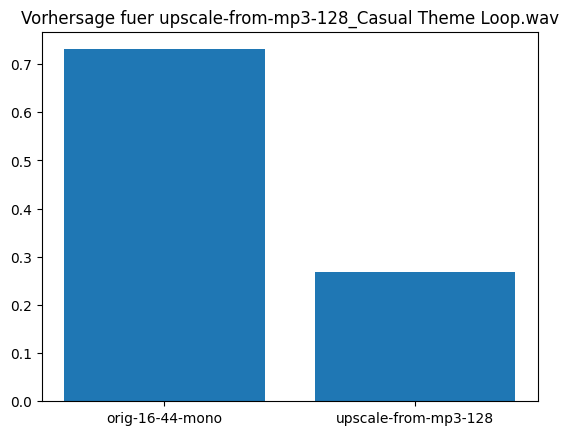

Verarbeite Datei: data\medium_test_ds\upscale-from-mp3-128\upscale-from-mp3-128_TRAINED_Action Time.wav
Form des Audiosignals: (44100,)
Sample Rate: 44100


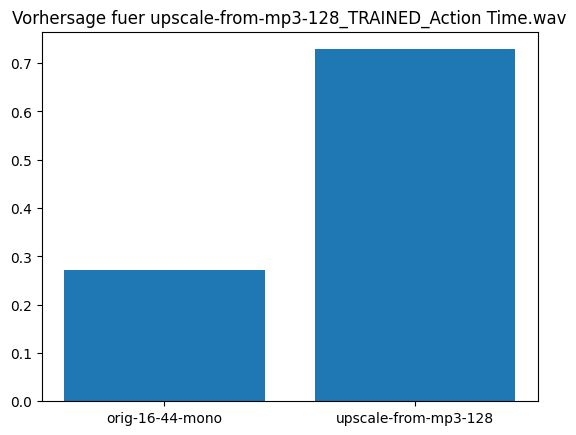

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x0000023781FCCB80>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x0000023781FCCB80>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


In [8]:
model, path = handle_ai_model.run(TEST_DIR, test_spectrogram_ds, val_spectrogram_ds, train_spectrogram_ds, history, model, label_names)

# USE MODEL

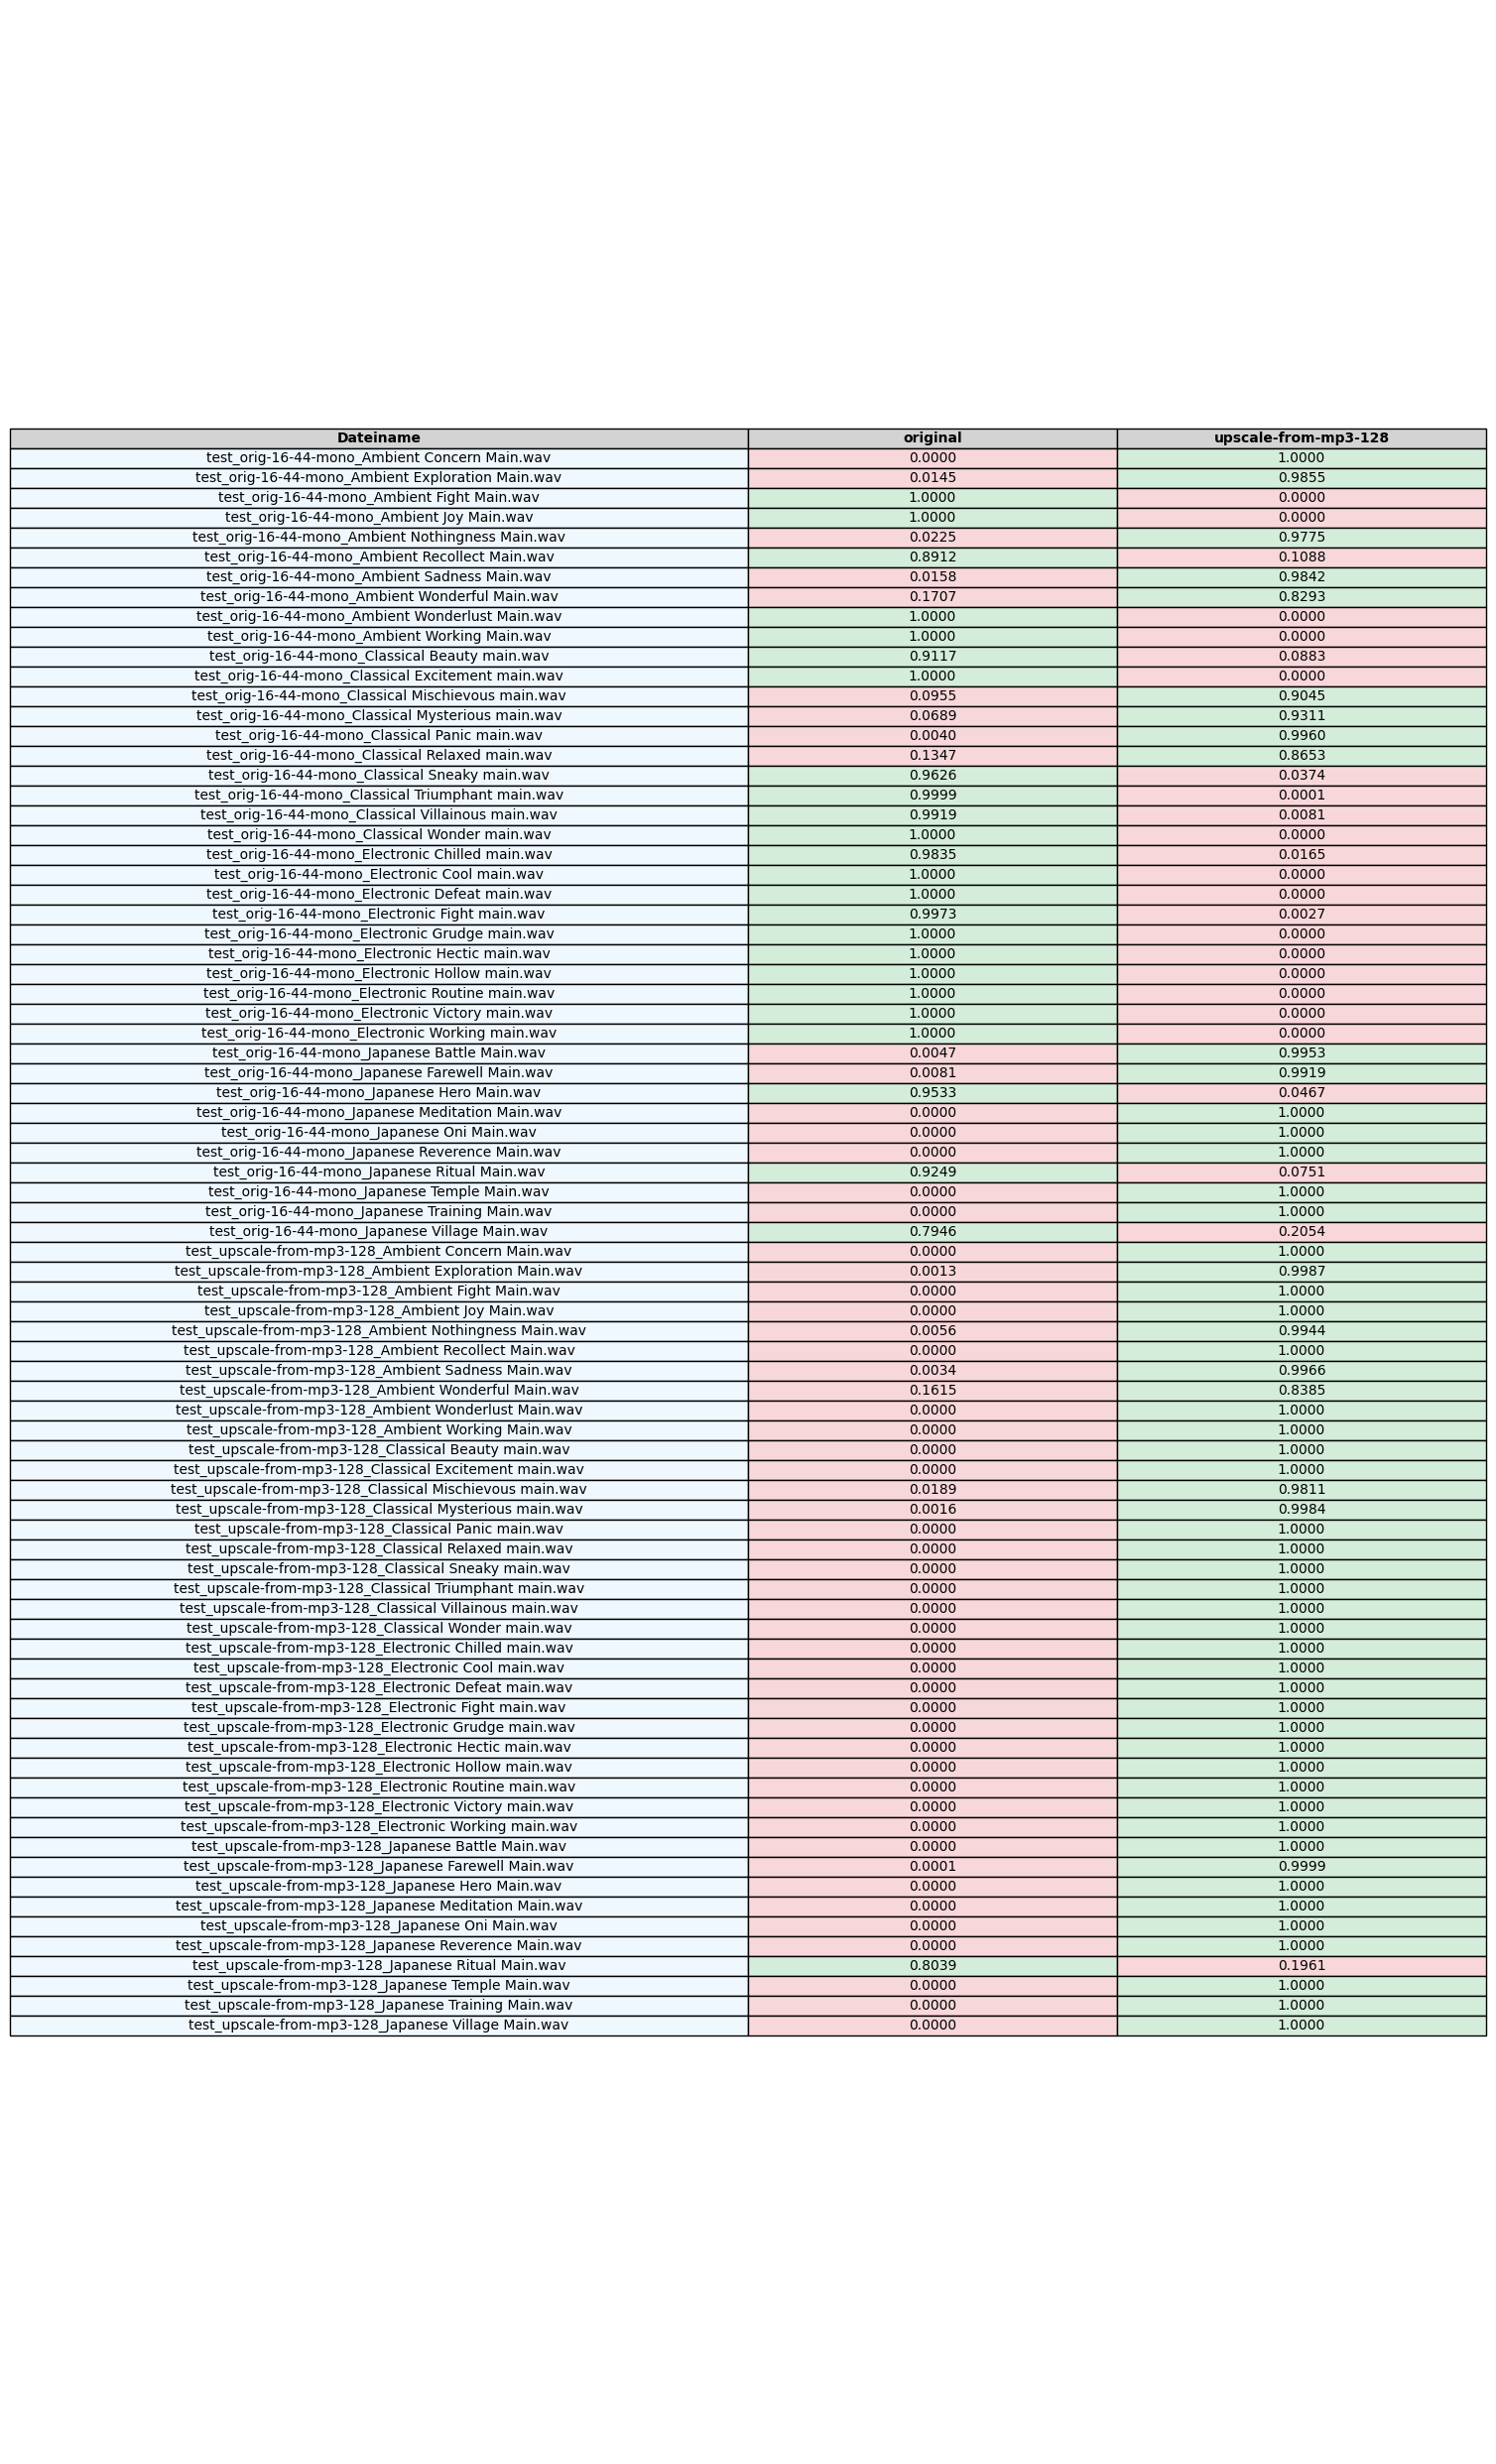

In [ ]:
import ipynb.fs.defs.use_model as use_model

use_model.run(path, SECONDS)

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The
  [TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.
